# <font color=navy> 6. A/B Test</font>

## 6.1 A/B test란? 
- 서로 다른 두 방법 간의 효과 차이를 밝히기 위한 통계적 디자인 패턴 
- <font color=green>임의로 나눈 두 집단</font>에 대해 서로 다른 방법을 적용하고 어떤 집단이 더 높은 성과를 보이는지 통계적으로 판단 

### Example: 신약 테스트
제약회사는 A 신약과 B 신약의 효능에 어떤 차이가 있는지 궁금하다. 회사는 환자 그룹 중 일정 비율을 대상으로 A 신약을, 나머지 환자를 대상으로 B 신약을 테스트할 것이다. 테스트 후 효능을 측정하여 어느 약이 더 나은지 판단한다. 

### Example: 웹사이트 전환율
프론트엔드 웹 개발자는 어느 웹사이트 디자인이 더 많은 전환율(conversion rate)을 내는지 알고 싶어한다. 웹 개발자는 방문객의 일부는 A사이트로 이동시키고, 나머지 방문객은 B사이트로 이동시킬 것이다. 그리고 방문객이 행동을 전환(회원가입/구매 등)하는지 여부를 기록한다. 이러한 배치와 전환율을 기록하여 이후에 어느 디자인이 효율적인지 판단한다. 
<img src="https://i0.wp.com/farm9.staticflickr.com/8734/17770510261_c223ccefe0_n.jpg?zoom=2&resize=320%2C252&ssl=1" width=400>

## 6.2 왜 A/B test?: 상관관계 vs. 인과관계 
#### Example: 아이스크림과 물놀이
한 지자체에서 물놀이 사고를 줄이는 것을 목표로 하고 있다. 조사 결과 아이스크림 판매량과 물놀이 사고 빈도 간의 상관관계가 높음을 알 수 있었다. 즉, 아이스크림 판매량이 증가하면 물놀이 사고가 증가하는 것이 데이터로부터 파악되었다. 따라서, 물놀이 사고를 줄이기 위해 아이스크림 가격을 올려 판매량을 줄이는 정책을 입안하였다!? 
- 아이스크림 판매량의 증가가 물놀이 사고 증가의 원인인가? (즉, 인과관계가 성립하는가?) 
- 아이스크림 판매량과 물놀이 사고 빈도에 동시에 영향을 주는 요인이 존재하기 때문에 두 변수 간의 상관관계가 관측되는 것
<img src='http://drive.google.com/uc?export=view&id=1vtvPmZRUQ3RFIyIU8dGP2UGBlWetx6Wa' width=300 /><br>

#### Example: 웹사이트 디자인과 매출 
어떤 쇼핑몰 웹 사이트가 있다. 3개월에 걸쳐 디자인 개편 프로젝트를 진행하였고 지난주에 성공적으로 새 디자인을 적용하였다. 그랬더니 갑자기 그 전에 비해 일 매출이 10% 증가했다. 매출 증가는 웹사이트 디자인 개편 덕분이다? 
- 새 디자인이 적용된 날 경쟁 쇼핑몰이 문을 닫았다면?
- 새 디자인이 적용된 날 경쟁력 있는 상품이 입고되었다면?
- 갑자기 경기가 좋아졌다면? 

#### A/B Test와 인과관계 
새 디자인을 적용하기 전의 매출과 새 디자인을 적용한 후의 매출을 비교하는 대신, **임의적으로 나눈** A 집단과 B 집단의 매출을 비교하면 시간의 흐름에 따라 발생하는 다른 요인들(경쟁 쇼핑몰 부도, 신상품 입고, 경기 변동 등)이 통제 가능하여 순수하게 디자인 변화로 인한 매출 차이만을 가려낼 수 있다.
- A 집단과 B 집단은 성별, 소득수준, 방문시간대 등 매출에 영향을 주는 다른 요인들이 골고루 분포하게끔 **임의적으로** 나누는 것이 중요 

## 6.3 Frequentist의 A/B Test 

- 비교하고자 하는 값이 양적변수이면(매출액, 체류시간 등) **독립표본 T-검정(Two-sample T-test)**를 활용 
- 비교하고자 하는 값이 비율이면(CTR; Click-Through Rate, 구매율 등) **두 그룹 비율 비교 검정**을 활용


### Example: Session time
A 또는 B 웹사이트 디자인 중에서 어느 디자인에서 방문자가 머무르는 시간이 긴가? 

In [2]:
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import matplotlib
import datetime
import collections
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

%matplotlib inline
data_path = "./data/"

In [3]:
session_times = pd.read_csv(data_path + "web_page_data.csv")
session_times.Time = 100 * session_times.Time
session_times.head()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


In [3]:
session_times.groupby("Page").describe()

Time                                                         
       count        mean         std   min   25%    50%    75%    max
Page                                                                 
Page A  21.0  126.333333   88.463175  21.0  67.0   95.0  173.0  342.0
Page B  15.0  162.000000  101.136400  43.0  80.0  147.0  234.5  357.0


- 관심이 되는 모수: $\mu_1 - \mu_2$

    - $\mu_1$: Page A에서 평균 체류시간
    - $\mu_2$: Page B에서 평균 체류시간

- $\mu_1 - \mu_2$의 점추정 
    $${\hat \mu_1 - \hat \mu_2} =\bar x_1 - \bar x_2 $$


1. 가설 설정
    - $H_0$:
    - $H_a$:
    
    <br>
2. 가정 체크

    - 두 집단 모두 정규분포를 따른다. 
    - 정규분포를 따르지 않더라도 관측치 수가 충분히 많다면 $(n_1+n_2>30)$ 일반적으로 
    two-sample t-test를 사용할 수 있다. 


<AxesSubplot:title={'center':'Time'}, xlabel='[Page]'>

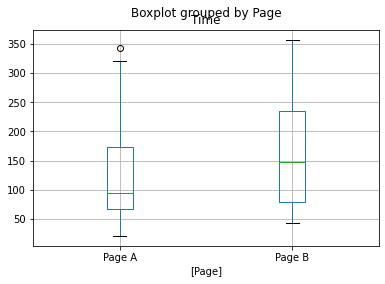

In [4]:
session_times.boxplot(by="Page")

3\. 검정통계량 계산 

$$ T=\frac{\bar x_1 - \bar x_2 }{\sqrt {var(\bar x_1 - \bar x_2)}}$$ 
$$var(\bar x_1 - \bar x_2) = \frac {\sigma_1^2} {n_1} +\frac {\sigma_2^2} {n_2}  $$

- $\frac {\sigma_1^2}{n_1} +\frac {\sigma_2^2}{n_2}$을 어떻게 추정할 것인가?

    - 두 집단의 분산이 같다는 정보가 있으면 $\sigma_1^2=\sigma_2^2$로 놓고 추정
        - `stats.ttest_ind(..., equal_var=True)`
    - 두 집단의 분산이 다르다는 정보가 있으면 각각 추정
        - `stats.ttest_ind(..., equal_var=False)`


##### 등분산 검정: Bartlett's Test
$$ H_0: \sigma_1^2 = \sigma_2^2 $$
$$H_a: \sigma_1^2 \neq \sigma_2^2 $$ 


In [5]:
stats.bartlett(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time)

BartlettResult(statistic=0.2901554845118482, pvalue=0.5901209093838491)

4\. 검정통계량과 p-value 계산 


In [4]:
from statsmodels.stats import weightstats
weightstats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      usevar='pooled',alternative = 'two-sided')

(-1.1237042154424814, 0.2690102436392606, 34.0)

5\. 결론
- T-test의 귀무가설을 기각하지 못한다. 
- 두 디자인의 평균 session time은 유의한 차이가 없다. 

### Example: 전환율 

A 또는 B 웹사이트 디자인 중에서 어느 디자인의 전환확률이 높은가?  A 사이트의 경우 1,300번 중 120번의 방문자가 전환을 했고 B 사이트의 경우 1275 중 125가 전환을 했다.

```python
visitors_to_A = 1300
visitors_to_B = 1275

conversions_from_A = 120
conversions_from_B = 125
```


- 관심 모수: $p_1 - p_2$
    - $p_1$: 모집단에서의 A의 전환확률
    - $p_2$: 모집단에서의 B의 전환확률

- 추정량: $\hat p_1 - \hat p_2$
    - $\hat p_1$: 표본에서의 A의 전환확률 
    - $\hat p_2$: 표본에서의 B의 전환확률

1\. 가설설정

- $H_0$:

- $H_a$:

      
 

2\. 가정체크
$$n_1 p_1\geq5, n_1(1-p_1)\geq5, n_2p_2\geq5, n_2(1-p_1)\geq5$$

3\. 검정통계량 

$$ Z=\frac{\hat p_1 - \hat p_2 }{\sqrt{\hat p (1-\hat p) \left( \frac 1 {n_1} + \frac 1 {n_2} \right) }} \sim N(0,1)$$

- $\hat p =\frac{n_1 \hat p_1 + n_2 \hat p_2 }{n_1+n_2}$ : pooled estimator

4\. 검정통계량, p-value, 결론 

In [5]:
from statsmodels.stats import proportion
ztest_result = proportion.proportions_ztest(count = [120,125], nobs = [1300,1275],  alternative = 'two-sided')

print('Z-statistics: %.3f, p-value: %.3f' %(ztest_result))

Z-statistics: -0.496, p-value: 0.620


- p-value>0.05: 두 웹페이지 디자인 간의 전환율의 유의적인 차이가 없다. 

## 6.4 Bayesian의 A/B Test

### Example: 전환율 
- Question
    -  A, B 중에서 어느 사이트의 전환확률이 높은가?
- (전환)확률에 대한 사전확률분포로는 Beta 분포가 적당 (why?)
    - Beta는 Binomial 분포의 성공확률 $p$에 대한 conjugate prior
    
만약 사전확률분포가 $\text{Beta} (\alpha_0, \beta_0)$ 이고 실험 $N$번, 성공 $X$개면 사후확률분포는 $\text{Beta}(\alpha_0 + X, \beta_0 + N - X)$ 이며 `SciPy`의 `beta`함수를 사용하여 사후확률분포에서 바로 표본을 추출할 수  있다.

In [4]:
visitors_to_A = 1300
visitors_to_B = 1275
conversions_from_A = 120
conversions_from_B = 125

In [7]:
from scipy.stats import beta

alpha_prior = 1
beta_prior = 1
posterior_A = beta(alpha_prior + conversions_from_A,
                   beta_prior + visitors_to_A - conversions_from_A)
posterior_B = beta(alpha_prior + conversions_from_B,
                   beta_prior + visitors_to_B - conversions_from_B)

In [8]:
samples = 20000 
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)
print ((samples_posterior_A > samples_posterior_B).mean())

0.3138


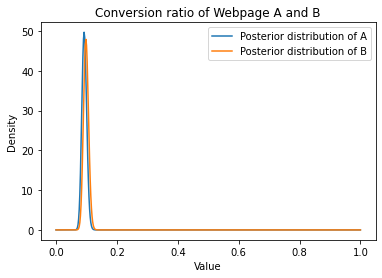

In [11]:
x = np.linspace(0,1, 500)
plt.plot(x, posterior_A.pdf(x), label='Posterior distribution of A')
plt.plot(x, posterior_B.pdf(x), label='Posterior distribution of B')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Conversion ratio of Webpage A and B")
plt.legend();

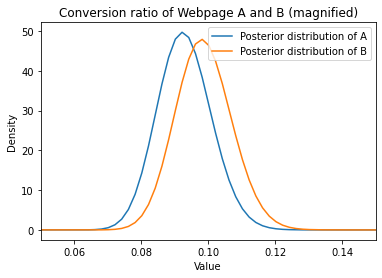

In [12]:
plt.plot(x, posterior_A.pdf(x), label='Posterior distribution of A')
plt.plot(x, posterior_B.pdf(x), label='Posterior distribution of B')
plt.xlim(0.05, 0.15)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Conversion ratio of Webpage A and B (magnified)")
plt.legend();

In [9]:
alpha_prior = 1
beta_prior = 1
with pm.Model() as model:
    p1 = pm.Beta('p1', alpha_prior, beta_prior)
    p2 = pm.Beta('p2', alpha_prior, beta_prior)
    x1= pm.Binomial('x1', visitors_to_A, p1, observed= conversions_from_A)
    x2= pm.Binomial('x2', visitors_to_B, p2, observed= conversions_from_B)
    p_diff = pm.Deterministic('p_diff', p1-p2)

In [11]:
with model:
    trace = pm.sample(2000)

<ipython-input-11-973ff0bd5fd9>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


C:\Users\JangSeongHyun\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'p1'}>,
       <AxesSubplot:title={'center':'p2'}>], dtype=object)

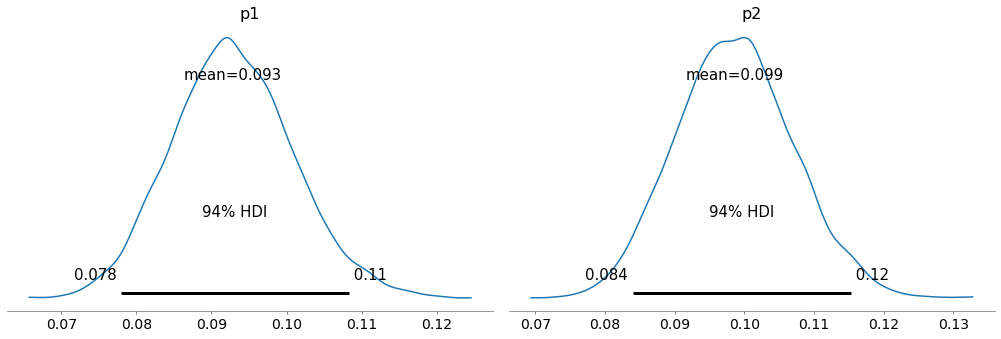

In [12]:
pm.plot_posterior(trace, var_names =['p1','p2'])

In [13]:
# E(p1|x1) - E(p2|x2) - posterior mean 의 차이
0.099-0.093 

0.006000000000000005

C:\Users\JangSeongHyun\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'p_diff'}>

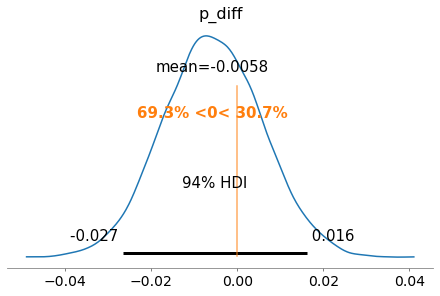

In [14]:
# p1 - p2 ?  E(p1-p2|x1,x2) - 우리가 궁금한 것은 p1-p2 값의 평균
pm.plot_posterior(trace, var_names =['p_diff'], ref_val=0)
# p1이 p2보다 크다고 30.7% 확신한다.

<ipython-input-15-4b673fced3da>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
C:\Users\JangSeongHyun\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'p1'}>,
        <AxesSubplot:title={'center':'p1'}>],
       [<AxesSubplot:title={'center':'p2'}>,
        <AxesSubplot:title={'center':'p2'}>],
       [<AxesSubplot:title={'center':'p_diff'}>,
        <AxesSubplot:title={'center':'p_diff'}>]], dtype=object)

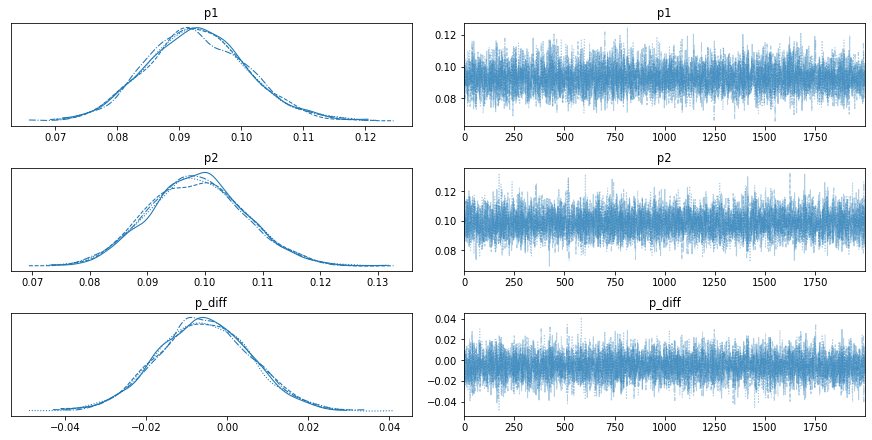

In [15]:
pm.traceplot(trace)

이정도면 converse가 잘 됐다고 볼 수 있다.